## Import Package

In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import statistics

#from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KDTree
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelBinarizer

# Classification
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgbm
import catboost as cat
from catboost import CatBoostClassifier, Pool
from imblearn.over_sampling import SMOTE
from sklearn import manifold, datasets
import optuna
import warnings
warnings.filterwarnings("ignore")

#remove outlier
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
import shap

## Upload Datasets

In [77]:
data=pd.read_csv(r"C:\Users\Chuxu\ESE527\googleplaystore.csv")
data.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


# Descriptive Analysis

## Data Cleaning

In [78]:
def clean_data(data):
    data = data.drop(['App','Current Ver','Android Ver'], axis=1)
    data[~data.Reviews.str.isnumeric()]
    data=data.drop(data.index[10472])
    items_to_remove=['+',',','$']                                   # Remove special symbols
    cols_to_clean=['Installs','Price','Size']
    for item in items_to_remove:
        for col in cols_to_clean:
            data[col]=data[col].str.replace(item,'')
    data['Installs'] = data['Installs'].astype('int')               # Change data type
    data['Price'] = data['Price'].astype('float')
    data['Reviews'] = data['Reviews'].astype('int')
    data['Size'] = data['Size'].str.replace('M','000')
    data['Size'] = data['Size'].str.replace('k','')
    data['Size'] = data['Size'].replace("Varies with device",np.nan)
    data['Size'] = data['Size'].astype('float')
    for i in data['Size']:
        if i < 10:
            data['Size'] = data['Size'].replace(i,i*1000)
    data['Size'] = data['Size']/1000
    data=data.dropna() # Remove all null value
    data.drop_duplicates(inplace=True) 
    # Convert the 'last_updated' column to datetime, specifying the format
    data['Last Updated'] = pd.to_datetime(data['Last Updated'], format='%B %d, %Y')
    # Reference date
    reference_date = pd.to_datetime("2018-08-08")
    data['Days_since_last_update'] = (reference_date - data['Last Updated']).dt.days # Calculate the number of days since the last update
    data = data.drop(['Last Updated'], axis=1)
    return data

In [79]:
data=clean_data(data)
data.head(5)

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Days_since_last_update
0,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,213
1,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,205
2,ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,7
3,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,61
4,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,49


## Data Visualization（Optional）

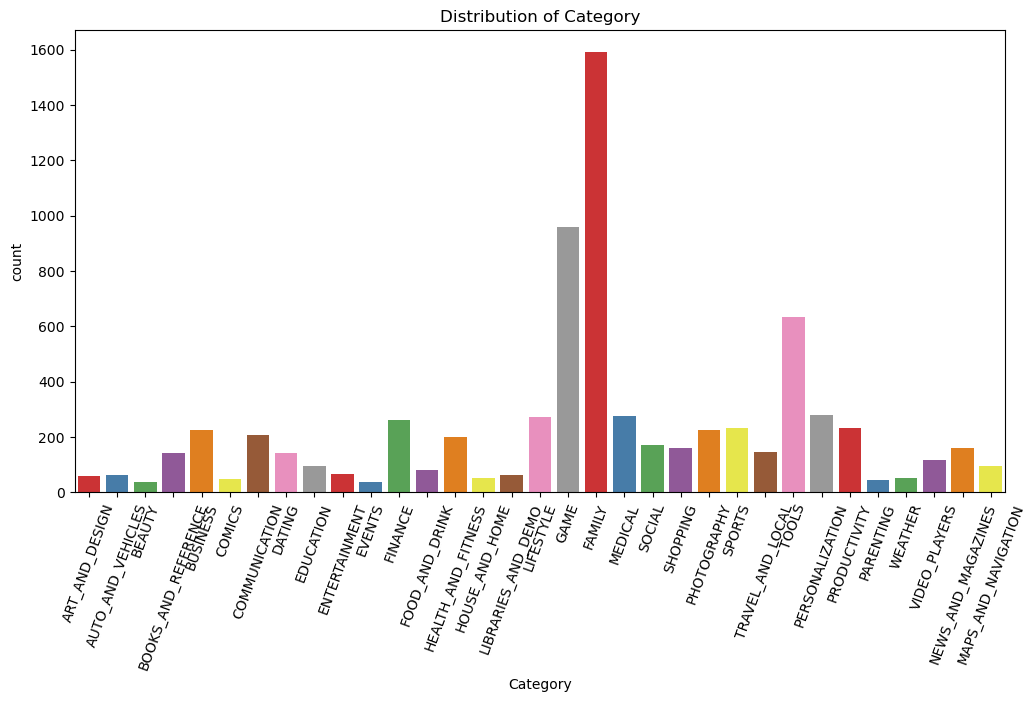

In [80]:
plt.rcParams['figure.figsize']=(12,6)
sns.countplot(x='Category',data=data,palette="Set1")
plt.xticks(rotation=70)
plt.title("Distribution of Category")
plt.show()

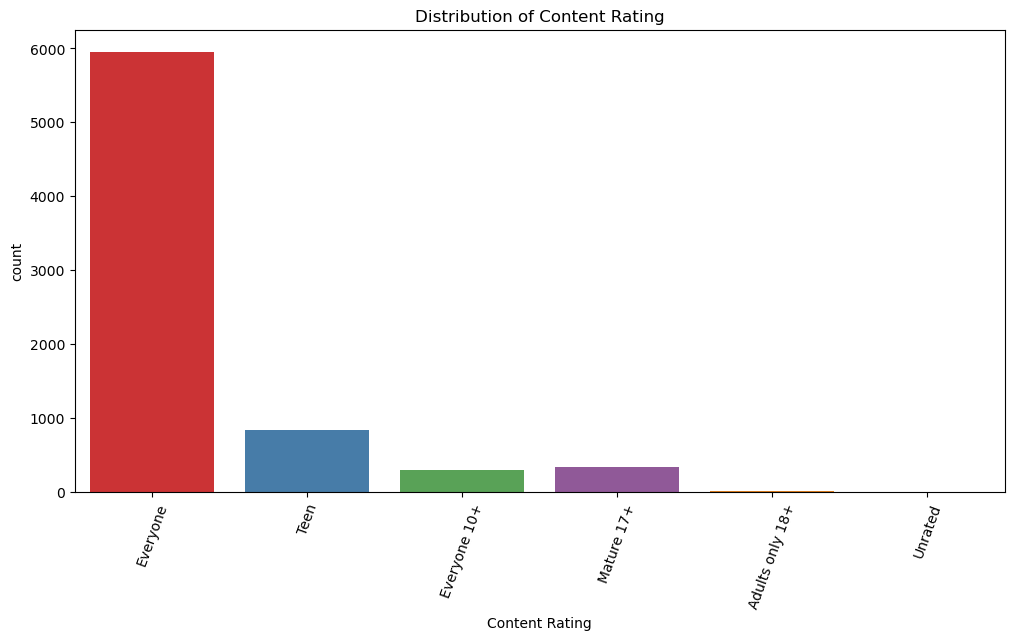

In [81]:
plt.rcParams['figure.figsize']=(12,6)
sns.countplot(x='Content Rating',data=data,palette="Set1")
plt.title("Distribution of Content Rating")
plt.xticks(rotation=70)
plt.show()

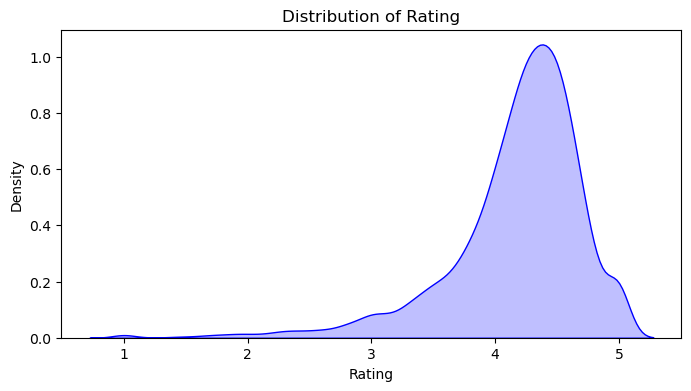

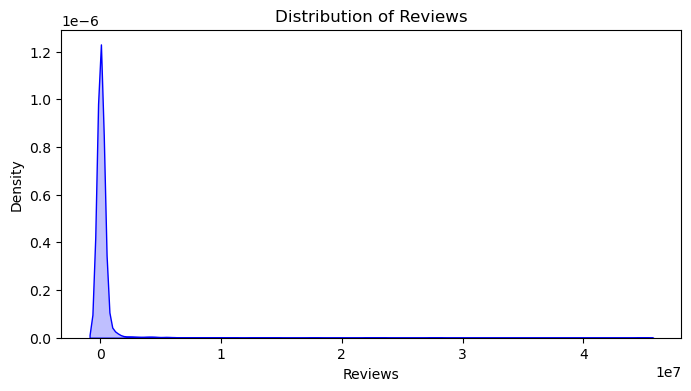

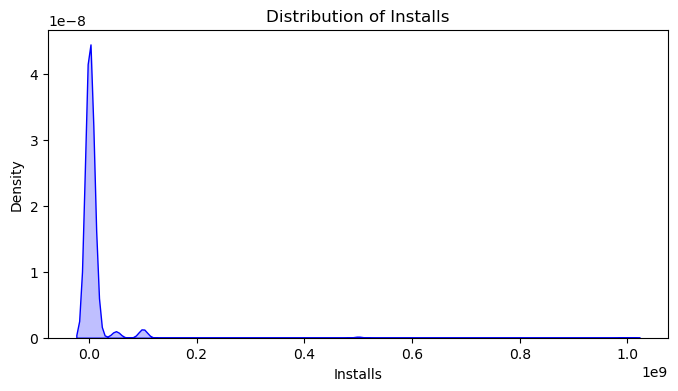

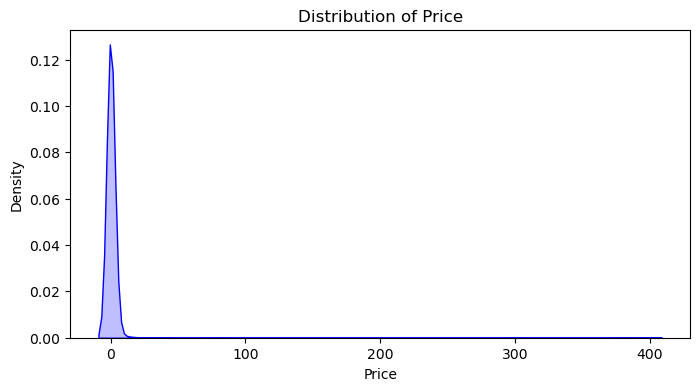

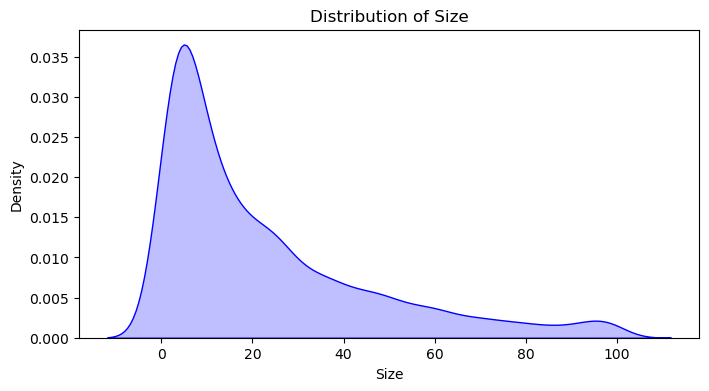

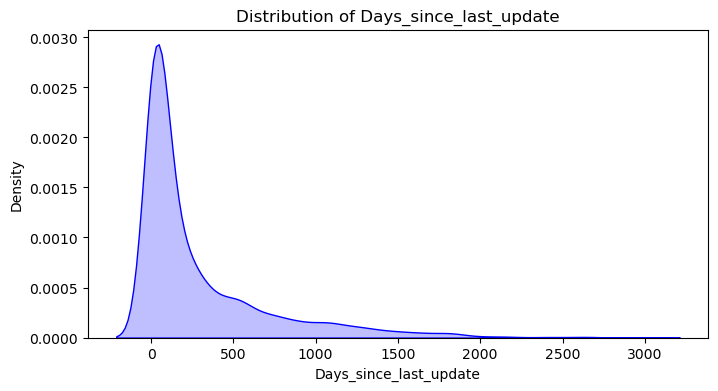

In [82]:
numeric_cols = ['Rating', 'Reviews', 'Installs', 'Price', 'Size', 'Days_since_last_update']
for i in range(6):
    plt.figure(figsize=(8,4))
    sns.kdeplot(data[numeric_cols[i]],color='blue',fill=True)
    plt.title("Distribution of "+numeric_cols[i])

Text(0.5, 1.0, 'Heatmap')

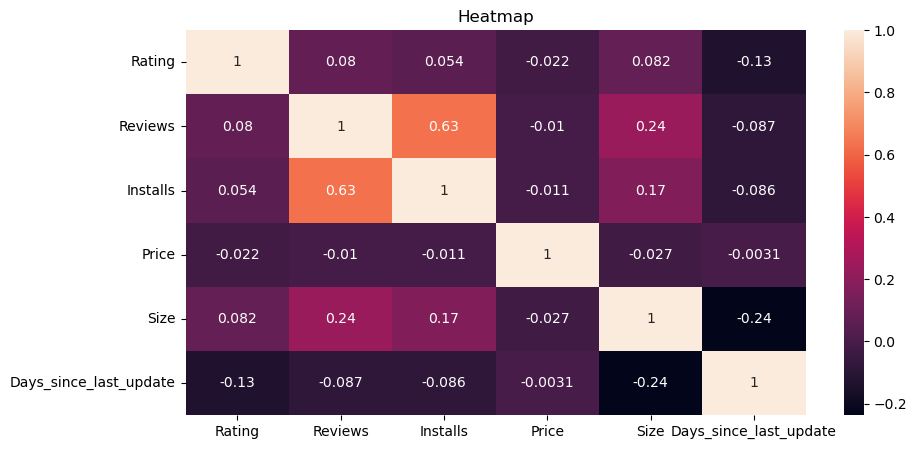

In [83]:
plt.rcParams['figure.figsize']=(10,5)
numeric_cols = ['Rating', 'Reviews', 'Installs', 'Price', 'Size', 'Days_since_last_update']
sns.heatmap(data[numeric_cols].corr(),annot=True)
plt.title("Heatmap")

## Data Encoding

Text(0.5, 1.0, 'Distribution of Rating')

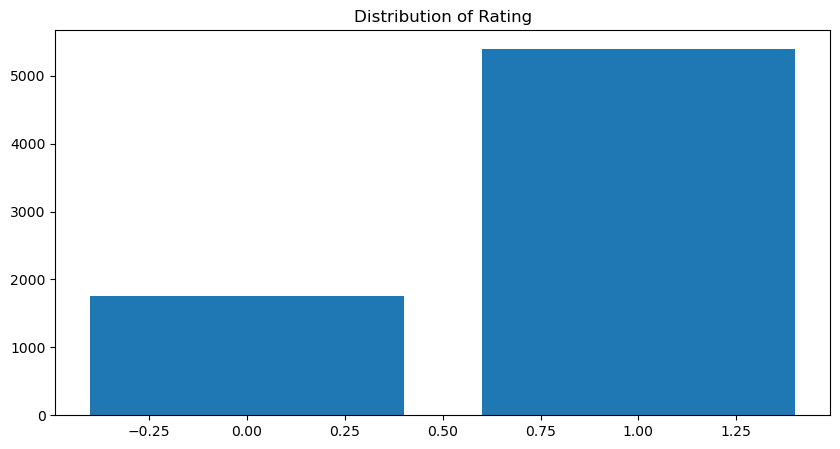

In [84]:
def categorize_rating(rating):
    if rating >= 0 and rating < 4.0:
        return 0
    elif rating >=4.0  and rating < 5:
        return 1
    else:
       return np.nan  # Return NaN for ratings that don't match any condition
# Apply the function to the 'Rating' column to create the 'Rating Interval' column
data['Rating Interval'] = data['Rating'].apply(categorize_rating)
plt.bar(data['Rating Interval'].value_counts().index,data['Rating Interval'].value_counts())
plt.title("Distribution of Rating")


Text(0.5, 1.0, 'Distribution of Rating')

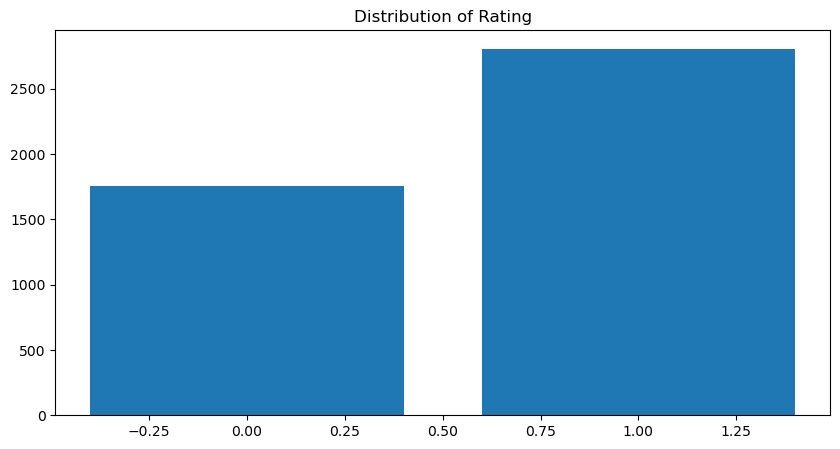

In [85]:
class_1 = data[data['Rating Interval'] == 1]
class_0 = data[data['Rating Interval'] == 0]
# 随机抽样类别1的一半数据
class_1_reduced = class_1.sample(frac=0.52, random_state=42)
# 合并类别0的数据和降采样后的类别1数据
data = pd.concat([class_0, class_1_reduced], ignore_index=True)

data['Rating Interval'] = data['Rating'].apply(categorize_rating)
plt.bar(data['Rating Interval'].value_counts().index,data['Rating Interval'].value_counts())
plt.title("Distribution of Rating")

In [59]:
data = pd.get_dummies(data, columns=['Category', 'Content Rating','Genres','Type'], dtype=float)
data.head(5)

,Rating,Reviews,Size,Installs,Price,Days_since_last_update,Rating Interval,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,...,Genres_Strategy;Creativity,Genres_Strategy;Education,Genres_Tools,Genres_Travel & Local,Genres_Trivia,Genres_Video Players & Editors,Genres_Weather,Genres_Word,Type_Free,Type_Paid
0,3.9,967,14.0,500000,0.0,205,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.8,178,19.0,50000,0.0,104,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.2,55,2.7,5000,0.0,63,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3.9,136,4.6,10000,0.0,27,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3.8,564,9.2,100000,0.0,28,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Standardization

In [60]:
def Standardization(dataframe):
    df_std = dataframe.copy()
    for col in df_std.columns:
        df_std[col] =(df_std[col]-df_std[col].mean())/df_std[col].std()
    return df_std

def Normalization(dataframe):
    df_norm = dataframe.copy()
    for col in df_norm.columns:
        df_norm[col] = (df_norm[col] - df_norm[col].min())/(df_norm[col].max() - df_norm[col].min())
    return df_norm

In [61]:
features = data[['Rating','Reviews', 'Price', 'Size', 'Installs','Days_since_last_update']]
features_scaled = Normalization(np.log1p(features))  # StandardScaler().fit_transform(features)
features_scaled 

,Rating,Reviews,Price,Size,Installs,Days_since_last_update
0,0.828327,0.365229,0.0,0.585885,0.598505,0.665399
1,0.809267,0.265513,0.0,0.648354,0.476879,0.581234
2,0.685833,0.196862,0.0,0.281940,0.355261,0.519404
3,0.828327,0.249715,0.0,0.371933,0.391870,0.416160
4,0.809267,0.333420,0.0,0.502139,0.513492,0.420542
...,...,...,...,...,...,...
4721,0.918143,0.412318,0.0,0.250414,0.598505,0.683433
4722,0.883256,0.064904,0.0,0.314574,0.233729,0.595812
4723,0.865307,0.502584,0.0,0.900929,0.635119,0.645031
4724,0.935105,0.832482,0.0,0.900929,0.756746,0.386041


Text(0.5, 1.0, 'Distribution of Size')

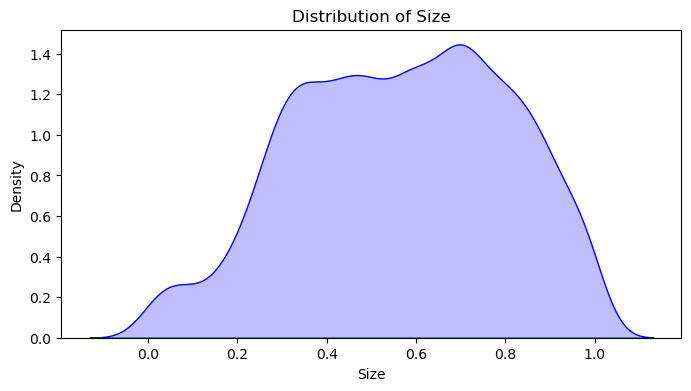

In [64]:
plt.figure(figsize=(8,4))
sns.kdeplot(features_scaled['Size'],color='blue',fill=True)
plt.title("Distribution of Size")

## Outlier Detection

### DB-SCAN

In [41]:
features = data[['Rating','Reviews', 'Price', 'Size', 'Installs','Days_since_last_update']]
dbscan = DBSCAN(eps=1, min_samples=5)
clusters_db = dbscan.fit_predict(features_scaled)
data_db = data[clusters_db != -1]
data_db_preview = data_db[['Rating','Price', 'Reviews', 'Size', 'Installs','Days_since_last_update']]
print(len(data) - len(data_db))
data_db_preview

339


,Rating,Price,Reviews,Size,Installs,Days_since_last_update
0,3.9,0.0,967,14.0,500000,205
1,3.8,0.0,178,19.0,50000,104
2,3.2,0.0,55,2.7,5000,63
3,3.9,0.0,136,4.6,10000,27
4,3.8,0.0,564,9.2,100000,28
...,...,...,...,...,...,...
4721,4.4,0.0,2147,2.2,500000,237
4722,4.2,0.0,5,3.3,500,117
4723,4.1,0.0,9898,63.0,1000000,174
4724,4.5,0.0,2634605,63.0,10000000,21


### IsolationForest（Optional）

In [264]:
clf = IsolationForest(random_state=0)
clusters_if = clf.fit_predict(features_scaled)
non_outlier_indices_if = (clusters_if != -1)
data_if = data[non_outlier_indices_if]
outliers_removed = len(data) - len(data_if)
data_if_preview = data_if[['Rating','Price', 'Reviews', 'Size', 'Installs','Days_since_last_update']]
outliers_removed, data_if_preview


(656,
       Rating  Price  Reviews  Size  Installs  Days_since_last_update
 0        3.9    0.0      967  14.0    500000                     205
 1        3.8    0.0      178  19.0     50000                     104
 2        3.2    0.0       55   2.7      5000                      63
 3        3.9    0.0      136   4.6     10000                      27
 4        3.8    0.0      564   9.2    100000                      28
 ...      ...    ...      ...   ...       ...                     ...
 4300     4.4    0.0    26252  24.0   1000000                      74
 4301     4.1    0.0    35771   3.5   5000000                      96
 4302     4.0    0.0     8941  12.0   5000000                       8
 4303     4.5    0.0      144   4.7     10000                      20
 4304     4.7    0.0    56197  15.0   1000000                       2
 
 [3650 rows x 6 columns])